In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from scipy import stats
import math 
from sklearn.preprocessing import LabelEncoder
import shap
import os
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
import pickle
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score,f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import sorted_idxisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE

%matplotlib inline

In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_rows = 200
pd.options.display.max_columns = 150

In [3]:
#Reading the Dataset
new_data=pd.read_csv('accepted_2007_to_2018Q4.csv',low_memory=False)

In [4]:
new_data.shape

(2260701, 151)

In [5]:
#Response/Target Variable 
new_data.loan_status.value_counts()

#Considering only Fully Paid, Default, Charged Off Loans.
resp=['Current']
Loan_Main = new_data[~new_data['loan_status'].isin(resp)] 
Loan_Main["loan_status"] = np.where(Loan_Main["loan_status"].str.contains("Fully"), 0, 1)

#New Dataset shape
Loan_Main.shape

# Changing employee length to numerical.
Loan_Main['emp_length'].fillna("< 1 year",inplace= True)
dict_emp_length = {'10+ years':10, '6 years':6, '4 years':4, '< 1 year':0.5, '2 years':2,'9 years':9, '5 years':5, '3 years':3, '7 years':7, '1 year':1,'8 years':8}
Loan_Main['emp_length'].replace(dict_emp_length, inplace=True)



#Seperating Loan_Main dataset into two based on Application_Type (Individual / Joint Type)
grouped = Loan_Main.groupby(Loan_Main.application_type)
Individual_Loan=grouped.get_group("Individual")
Joint_Loan=grouped.get_group("Joint App")

In [6]:
Joint_Loan.shape

(29584, 151)

In [7]:
Joint_Loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,...,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10.0,MORTGAGE,63000.00,Not Verified,Dec-2015,0,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,w,0.0,0.0,22705.924294,22705.92,20000.00,2705.92,0.0,0.00,0.0000,Jun-2017,15813.30,NaN,Mar-2019,704.0,700.0,0.0,NaN,1.0,Joint App,71000.00,13.85,Not Verified,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,14000.0,...,5.0,1.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,NaN,10.0,NaN,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
438,68340637,NaN,15000.0,15000.0,15000.0,36 months,11.99,498.15,C,C1,Lead Tech,1.0,MORTGAGE,65000.00,Source Verified,Dec-2015,0,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,NaN,919xx,CA,17.56,0.0,Aug-2004,665.0,669.0,0.0,54.0,NaN,9.0,0.0,13028.0,88.3,16.0,w,0.0,0.0,15183.460000,15183.46,15000.00,183.46,0.0,0.00,0.0000,Feb-2016,15208.44,NaN,Feb-2016,769.0,765.0,0.0,NaN,1.0,Joint App,77000.00,15.40,Not Verified,0.0,0.0,231860.0,0.0,0.0,0.0,0.0,30.0,22525.0,74.0,0.0,2.0,2839.0,78.0,14800.0,...,1.0,2.0,2.0,25762.0,295.0,94.2,0.0,0.0,99.0,136.0,13.0,13.0,1.0,28.0,NaN,11.0,54.0,0.0,2.0,7.0,2.0,3.0,4.0,7.0,11.0,7.0,9.0,0.0,0.0,0.0,0.0,92.3,100.0,0.0,0.0,251645.0,35553.0,5100.0,30649.0,NaN,NaN,

In [8]:
col=['purpose']
enc= LabelEncoder()
Joint_Loan.loc[:,col]= Joint_Loan.loc[:,col].apply(enc.fit_transform)

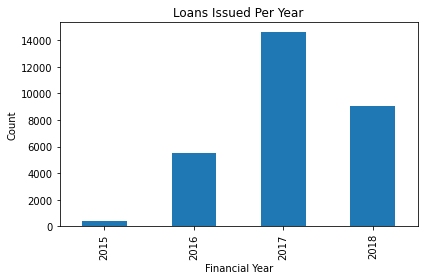

In [9]:
Joint_Loan['issue_d'] = pd.to_datetime(Joint_Loan['issue_d'])

Joint_Loan['issue_d'].dt.year.value_counts().sort_index().plot.bar()
plt.title('Loans Issued Per Year')
plt.xlabel('Financial Year')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

In [10]:
#set fraction
frac = 0.80
#get fractions and make deep copy
df_train = Joint_Loan.loc[Joint_Loan['issue_d']  < Joint_Loan['issue_d'].quantile(frac)]
df_test =  Joint_Loan.loc[Joint_Loan['issue_d'] >= Joint_Loan['issue_d'].quantile(frac)]

In [11]:
#save as compressed zipped files to save space
df_test.to_csv('data/df_test_jl.csv')
df_train.to_csv('data/df_train_jl.csv')

In [12]:
leak_cols = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 
             'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 
             'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'inq_last_6mths', 'last_credit_pull_d', 
             'initial_list_status', 'mo_sin_old_rev_tl_op', 'mo_sin_old_il_acct','last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
             'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'sec_app_collections_12_mths_ex_med',
             'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 
             'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',  
             'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq',     'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 
             'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'last_fico_range_high','last_fico_range_low','url','id','title','addr_state',
             'tot_hi_cred_lim','total_bal_ex_mort', 'total_bc_limit', 'sec_app_chargeoff_within_12_mths',
             'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 
             'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 
             'total_rev_hi_lim']
#drop leaks
df_small = df_train.drop(columns=leak_cols, axis=1)
drop_col_count = len(leak_cols)
print("The new dataframe has {} columns and lost {} after dropping future leaks".format(df_small.shape[1],
                                                                           drop_col_count))

The new dataframe has 84 columns and lost 67 after dropping future leaks


In [13]:
df_small.shape

(22963, 84)

In [14]:
#remove columns that have only 1 feature
#get unique values per feature
nunique_value = df_small.apply(pd.Series.nunique)
#note columns that have single value
single_value_cols = nunique_value[nunique_value == 1].index.tolist()
print(single_value_cols)

['policy_code', 'application_type', 'hardship_type', 'deferral_term', 'hardship_length']


In [15]:
# drop the redundant columns
df_small = df_small.drop(columns=single_value_cols)

In [16]:
#make dataframe to record mean missing
nan_df = pd.DataFrame(df_small.isna().mean(), columns=['mean_nan'])
#add dtypes
nan_df['dtypes'] = df_small.dtypes
#sort by most missing at top
nan_df = nan_df.sort_values(by=['mean_nan'], ascending=False)

nan_df = nan_df.reset_index()

nan_df.head()

,index,mean_nan,dtypes
0,member_id,1.000000,float64
1,desc,1.000000,object
2,orig_projected_additional_accrued_interest,0.988111,float64
3,hardship_last_payment_amount,0.983582,float64
4,hardship_payoff_balance_amount,0.983582,float64


In [17]:
a=df_small.isnull().sum()/len(df_small)*100
variables = df_small.columns
variable = [ ]
for i in range(0,len(df_small.columns)):
    if a[i]<50:   #setting the threshold as 90% (MissingValue)
        variable.append(variables[i])
 # Dropping Columns based on missing data being more than 60% 
drop_columns1=list(set(variables) - set(variable))
df_drop_nan=df_small.drop(columns=drop_columns1)

In [18]:
df_drop_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22963 entries, 2 to 2260663
Data columns (total 53 columns):
loan_amnt                    22963 non-null float64
term                         22963 non-null object
int_rate                     22963 non-null float64
installment                  22963 non-null float64
grade                        22963 non-null object
sub_grade                    22963 non-null object
emp_title                    19652 non-null object
emp_length                   22963 non-null float64
home_ownership               22963 non-null object
annual_inc                   22963 non-null float64
verification_status          22963 non-null object
issue_d                      22963 non-null datetime64[ns]
loan_status                  22963 non-null int32
purpose                      22963 non-null int32
zip_code                     22963 non-null object
dti                          22680 non-null float64
earliest_cr_line             22963 non-null object
fico_range

In [127]:
import sweetviz
my_report = sweetviz.analyze([df_drop_nan.drop(columns='issue_d'), "Training Data"], target_feat= "loan_status")

:FEATURES DONE:                    |█████████████████████| [100%]   00:21  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:06  -> (00:00 left)


Creating Associations graph... DONE!


In [42]:
my_report.show_html('Joint_Loan.html')

In [19]:
def df_object_to_num(df_obj):
    
    """Custom function to transform categorical features into numerical ones
    This function will also be applied on the testing data so that we apply the same exact kind of transformation
    """
    
    #make deep copy
    df_num = df_obj.copy()
    
    col_drop_list = ['emp_title']
    
    df_num['mort_acc'] = np.where(df_num['mort_acc'].isnull(), 0,df_num['mort_acc'])
    #pub_rec_bankruptcies
    df_num['pub_rec_bankruptcies'] = np.where(df_num['pub_rec_bankruptcies']>0, 1, 0)
    # pub_rec
    df_num['pub_rec'] = np.where(df_num['pub_rec']>0, 1, 0)
    
     ### instantiate dicts ### 
    term_to_int = {' 36 months': 1,
                   ' 60 months': 2}
    grade_to_int = dict(zip(['A', 'B', 'C', 'D', 'E', 'F', 'G'], np.arange(7, 0, -1)))
    #copied from above, we can write a function to generate this dict
    sub_grade_sorted = {'G5': 0, 'G4': 1, 'G3': 2, 'G2': 3, 'G1': 4,
                        'F5': 5, 'F4': 6, 'F3': 7, 'F2': 8, 'F1': 9,
                        'E5': 10, 'E4': 11, 'E3': 12, 'E2': 13, 'E1': 14,
                        'D5': 15, 'D4': 16, 'D3': 17, 'D2': 18, 'D1': 19,
                        'C5': 20, 'C4': 21, 'C3': 22, 'C2': 23, 'C1': 24,
                        'B5': 25, 'B4': 26, 'B3': 27, 'B2': 28, 'B1': 29,
                        'A5': 30, 'A4': 31, 'A3': 32, 'A2': 33, 'A1': 34}    
    home_to_int = {'MORTGAGE': 4, 'RENT': 3, 'OWN': 5,'ANY': 2,'OTHER': 1, 'NONE':0 }
    ver_stat_to_int = {'Source Verified':2,'Verified': 1,'Not Verified': 0} 
    #replacements
    df_num['verification_status_joint'] = np.where(df_num['verification_status_joint'].isnull(), 'Not Verified',df_num['verification_status_joint'])

    df_num.replace({'term': term_to_int, 
                    'grade':grade_to_int,
                    'sub_grade': sub_grade_sorted,
                    'home_ownership':home_to_int,
                    'verification_status':ver_stat_to_int,
                   'verification_status_joint':ver_stat_to_int}, inplace=True)
    col_drop_list.append('zip_code')
    
    df_num['il_util'] = np.where(df_num['il_util'].isnull(),df_num['il_util'].mean() , df_num['il_util'])
    df_num['revol_util'] = np.where(df_num['revol_util'].isnull(),df_num['revol_util'].mean() , df_num['revol_util'])
    df_num['dti'] = np.where(df_num['dti'].isnull(),df_num['dti'].mean() , df_num['dti'])

    df_num['fico_avg_score'] = (df_num['fico_range_high']+df_num['fico_range_low'] )/2
    col_drop_list.extend(['fico_range_high','fico_range_low'])

    df_num['sec_fico_avg_score'] = (df_num['sec_app_fico_range_high']+df_num['sec_app_fico_range_low'] )/2
    col_drop_list.extend(['sec_app_fico_range_high','sec_app_fico_range_low'])
    
    df_num['earliest_cr_line']=  pd.to_datetime(df_num['earliest_cr_line'], infer_datetime_format=True)
    df_num['issue_d']=  pd.to_datetime(df_num['issue_d'], infer_datetime_format=True)
    credit_hist= df_num['issue_d'] - df_num['earliest_cr_line']
    df_num['credit_hist']=credit_hist.dt.days
    col_drop_list.append('earliest_cr_line')

    df_num['sec_app_earliest_cr_line']=  pd.to_datetime(df_num['sec_app_earliest_cr_line'], infer_datetime_format=True)
    df_num['issue_d']=  pd.to_datetime(df_num['issue_d'], infer_datetime_format=True)
    credit_hist= df_num['issue_d'] - df_num['sec_app_earliest_cr_line']
    df_num['sec_credit_hist']=credit_hist.dt.days
    col_drop_list.append('sec_app_earliest_cr_line')
    col_drop_list.append('issue_d')
    
   

    #Balance_annual_income
    df_num['balance_annual_inc'] = np.where(df_num['annual_inc']==0,0 , df_num['loan_amnt'] / df_num['annual_inc'])
    
    #Balance_annual_income
    df_num['sec_balance_annual_inc'] = np.where(df_num['annual_inc_joint']==0,0 , df_num['loan_amnt'] / df_num['annual_inc_joint'])
    
    df_num['annual_inc']+=1
    df_num['annual_inc_joint']+=1
    df_num['annual_inc']=np.log(df_num['annual_inc'])
    df_num['total_bal_il']+=1
    df_num['total_bal_il']=np.log(df_num['total_bal_il'])
    df_num['revol_bal']+=1
    df_num['revol_bal']=np.log(df_num['revol_bal'])
    df_num['revol_bal_joint']+=1
    df_num['revol_bal_joint']=np.log(df_num['revol_bal_joint'])
    df_num['annual_inc_joint']=np.log(df_num['annual_inc_joint'])
    df_num['max_bal_bc']+=1
    df_num['max_bal_bc']=np.log(df_num['max_bal_bc'])
    
    df_num['inst_amnt_ratio']=df_num['installment']/df_num['loan_amnt']
    col_drop_list.extend(['installment','loan_amnt'])
    
     # credit_line_ratio 
    df_num['credit_line_ratio']=df_num['open_acc']/df_num['total_acc']
    col_drop_list.extend(['open_acc','total_acc'])
    
    df_num  = df_num.drop(columns=col_drop_list)
    df_num=df_num.dropna()

    return df_num

    
    
    
    

In [20]:
#make entries numerical
df_num = df_object_to_num(df_drop_nan)
df_num.head()

,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,pub_rec,revol_bal,revol_util,annual_inc_joint,dti_joint,verification_status_joint,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,mort_acc,pub_rec_bankruptcies,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,fico_avg_score,sec_fico_avg_score,credit_hist,sec_credit_hist,balance_annual_inc,sec_balance_annual_inc,inst_amnt_ratio,credit_line_ratio
459321,1,10.91,6,26,10.0,4,11.225257,1,0,2,38.240000,0,9.832689,59.5,11.782960,25.23,1,0.0,5.0,1.0,2.0,12.0,12.161630,67.0,2.0,2.0,8.636930,64.0,0.0,1.0,1.0,1.0,0,10.778143,0.0,1.0,6.0,49.3,3.0,9.0,717.0,612.0,5054,7489.0,0.160000,0.091603,0.032697,0.323529
459376,1,30.75,2,5,10.0,4,11.350418,1,1,2,16.070000,1,8.909641,31.4,11.487618,14.31,1,4.0,3.0,2.0,2.0,2.0,10.523903,99.0,3.0,3.0,8.421343,73.0,2.0,1.0,7.0,3.0,0,9.944582,1.0,0.0,6.0,31.5,1.0,7.0,697.0,577.0,4689,2254.0,0.401471,0.350000,0.042864,0.769231
459384,1,16.02,5,20,10.0,4,11.018646,1,0,2,7.630000,1,8.386173,31.3,11.669938,3.98,1,1.0,1.0,1.0,1.0,9.0,8.725670,77.0,2.0,2.0,7.575585,48.0,0.0,2.0,1.0,1.0,1,9.263312,0.0,1.0,3.0,88.5,0.0,3.0,692.0,657.0,8189,5451.0,0.102049,0.053205,0.035168,0.636364
459431,2,19.42,4,17,0.5,4,0.000000,0,0,2,32.176832,0,8.768885,50.2,11.512935,9.00,0,0.0,0.0,1.0,1.0,8.0,9.494165,81.0,1.0,1.0,8.586906,67.0,0.0,0.0,2.0,0.0,0,9.199987,2.0,0.0,8.0,58.2,0.0,7.0,717.0,667.0,3045,5329.0,0.000000,0.144000,0.026172,0.714286
459617,2,20.39,4,16,1.0,3,11.407576,0,1,1,43.110000,0,10.930854,94.1,12.022018,32.96,0,0.0,5.0,1.0,3.0,8.0,11.444122,44.0,0.0,2.0,9.493412,67.0,2.0,1.0,11.0,2.0,0,11.465173,1.0,2.0,18.0,75.1,4.0,22.0,682.0,672.0,8738,8677.0,0.266667,0.144251,0.026712,0.500000


In [21]:
#drop leak columns
df_test = df_test.drop(columns=leak_cols, axis=1)

# drop the redundant columns
df_test = df_test.drop(columns=single_value_cols)

#drop the columns
df_test = df_test.drop(columns=drop_columns1)

In [22]:
#make numerical
df_test_num = df_object_to_num(df_test)

In [23]:
#save as compressed zipped files to save space
df_num.to_csv('data/df_train_jl_scale.csv')

In [24]:
ss = StandardScaler()
df_train_num=df_num.copy()

target_col = 'loan_status'

#feature space
X_train = df_train_num.drop(columns=[target_col])
X_test = df_test_num.drop(columns=[target_col])

#target variable
y_train = df_train_num[target_col]
y_test = df_test_num[target_col]


X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [25]:
#ROC dict for TPR and FPR values
roc_dict = {}

#precision recall curve
prc_dict = {}


def modify_roc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for ROC metrics
    """
    
    fpr, tpr, thresholds = roc_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    
    clf_roc_dict = {'fpr':fpr, 'tpr': tpr, 'thresholds': thresholds}
    
    dict_modify[name] = clf_roc_dict
    
def modify_prc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for precision recall metrics
    """
    
    precision, recall, thresholds = precision_recall_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    clf_prc_dict = {'precision':precision, 'recall': recall, 'thresholds': thresholds}
    
    dict_modify[name] = clf_prc_dict

In [26]:
def fit_score_clf(clf, X_train, y_train, X_test, y_test, name='clf'):
    """
    fits a classifer from sklearn and returns a dataframe
    clf(sklearn): classifier
    X_train(numpy): train features
    y_train(numpy): predictions row vector
    X_test(numpy): test features
    y_test(numpy): ground truth row vector
    name(string): name of classifier
    
    """
    #fit to train data
    clf.fit(X_train, y_train)
    #make predictions
    y_pred = clf.predict(X_test)
    #make dataframe from report
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    #add clf name as column
    clf_report['clf'] = name
    
    return clf_report

In [27]:
#instantiate with default params
lr  = LogisticRegression(penalty='l2',
                         C=1.0,
                         solver = 'lbfgs',
                         max_iter=400,
                         n_jobs=-1)

lr_report = fit_score_clf(lr, X_train, y_train, X_test, y_test, name='lr')
lr_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.682568,0.586235,0.663941,0.634402,0.646982,lr
recall,0.873125,0.306858,0.663941,0.589991,0.663941,lr
f1-score,0.766176,0.402849,0.663941,0.584512,0.631960,lr
support,3933.000000,2304.000000,0.663941,6237.000000,6237.000000,lr


In [28]:
#metrics for lr
modify_roc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression', 
                dict_modify=roc_dict)
modify_prc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression',
                dict_modify=prc_dict)

In [29]:
gbtree = GradientBoostingClassifier(learning_rate=0.1, n_estimators = 100)

gbtree_report = fit_score_clf(gbtree, X_train, y_train, X_test, y_test, name='gbtree')
gbtree_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.695100,0.641304,0.684784,0.668202,0.675228,gbtree
recall,0.890923,0.332899,0.684784,0.611911,0.684784,gbtree
f1-score,0.780923,0.438286,0.684784,0.609604,0.654350,gbtree
support,3933.000000,2304.000000,0.684784,6237.000000,6237.000000,gbtree


In [30]:
#metrics for gbtree
modify_roc_dict(gbtree, y_test, X_test, name='GBTree',dict_modify=roc_dict)

In [31]:
modify_prc_dict(clf=gbtree,
                y_test=y_test,
                X_test=X_test,
                name='GBTree',
                dict_modify=prc_dict)

In [32]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

rf_report = fit_score_clf(rf, X_train, y_train, X_test, y_test, name='rf')
rf_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.684088,0.627451,0.674363,0.655770,0.663166,rf
recall,0.898551,0.291667,0.674363,0.595109,0.674363,rf
f1-score,0.776789,0.398222,0.674363,0.587505,0.636943,rf
support,3933.000000,2304.000000,0.674363,6237.000000,6237.000000,rf


In [33]:
#metrics for random forest
modify_roc_dict(rf, y_test, X_test, name='RandomForest',dict_modify=roc_dict)

In [34]:
modify_prc_dict(clf=rf,
                y_test=y_test,
                X_test=X_test,
                name='RandomForest',
                dict_modify=prc_dict)

In [50]:
xgb_clf = xgb.XGBClassifier(n_estimators=300,
                            subsample=0.9,
                            n_jobs=-1)

xgb_report = fit_score_clf(xgb_clf, X_train, y_train, X_test, y_test, name='xgb')
xgb_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.703569,0.588575,0.674844,0.646072,0.661089,xgb
recall,0.837020,0.398003,0.674844,0.617512,0.674844,xgb
f1-score,0.764515,0.474883,0.674844,0.619699,0.657522,xgb
support,3933.000000,2304.000000,0.674844,6237.000000,6237.000000,xgb


In [51]:
#metrics for svc
modify_roc_dict(xgb_clf, y_test, X_test, name='XGBoost',dict_modify=roc_dict)

In [52]:
modify_prc_dict(clf=xgb_clf,
                y_test=y_test,
                X_test=X_test,
                name='XGBoost',
                dict_modify=prc_dict)

In [53]:
#put hard limit on iterations to save time in exploration phase
svc = SVC(C=1.0, kernel='rbf',
          gamma='auto', 
          probability=True,
          max_iter=400)

svc_report = fit_score_clf(svc, X_train, y_train, X_test, y_test, name='svc')
svc_report.head()

Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


,0,1,accuracy,macro avg,weighted avg,clf
precision,0.647816,0.376320,0.454064,0.512068,0.547523,svc
recall,0.294177,0.726997,0.454064,0.510587,0.454064,svc
f1-score,0.404616,0.495929,0.454064,0.450273,0.438348,svc
support,3933.000000,2304.000000,0.454064,6237.000000,6237.000000,svc


In [54]:
#metrics for svc
modify_roc_dict(svc, y_test, X_test, name='SVC',dict_modify=roc_dict)

In [55]:
modify_prc_dict(clf=svc,
                y_test=y_test,
                X_test=X_test,
                name='SVC',
                dict_modify=prc_dict)

In [56]:
knn = KNeighborsClassifier(n_neighbors =5, n_jobs=-1)

knn_report = fit_score_clf(knn, X_train, y_train, X_test, y_test, name='KNN')
knn_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.650161,0.427481,0.594036,0.538821,0.567901,KNN
recall,0.771167,0.291667,0.594036,0.531417,0.594036,KNN
f1-score,0.705513,0.346749,0.594036,0.526131,0.572983,KNN
support,3933.000000,2304.000000,0.594036,6237.000000,6237.000000,KNN


In [57]:
#metrics for knn
modify_roc_dict(knn, y_test, X_test, name='KNN',dict_modify=roc_dict)

In [58]:
modify_prc_dict(clf=knn,
                y_test=y_test,
                X_test=X_test,
                name='knn',
                dict_modify=prc_dict)

In [59]:
#see keys we have
roc_dict.keys()

dict_keys(['Logistic Regression', 'GBTree', 'RandomForest', 'XGBoost', 'SVC', 'KNN'])

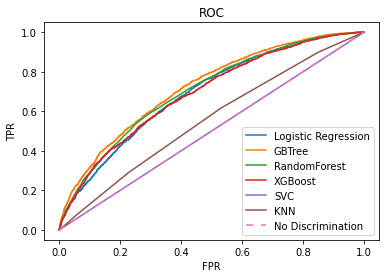

In [60]:
for key in roc_dict:
    clf = roc_dict[key]
    plt.plot(clf['fpr'], clf['tpr'], label=key)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.savefig(os.path.join('plots/roc_curve_all_models_J.png'))
plt.legend()
plt.show()

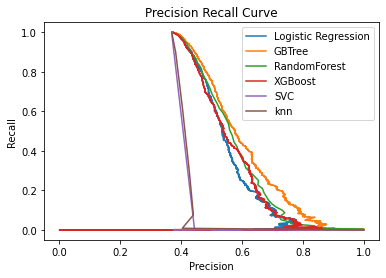

In [61]:
for key in prc_dict:
    clf = prc_dict[key]
    plt.plot(clf['precision'], clf['recall'], label=key)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision Recall Curve")
plt.savefig(os.path.join('plots/prc_curve_all_models.png'))

plt.legend()

plt.show()

In [62]:
gbtree.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[3292,  641],
       [1387,  917]], dtype=int64)

In [63]:
fpr, tpr, thresholds = roc_curve(y_test,gbtree.predict_proba(X_test)[:,1],pos_label=1)

In [64]:
precision, recall, thresholds = precision_recall_curve(y_test,
                                                       gbtree.predict_proba(X_test)[:,1],
                                                       pos_label=1)

In [65]:
gb_auc = roc_auc_score(y_test, gbtree.predict_proba(X_test)[:,1])
print("gb_auc: {}".format(gb_auc))

gb_auc: 0.7203209090812781


In [66]:
#define location to save trained model
save_model_dir = os.path.join('models/gb_default_params_joint.pickle')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(xgb_clf,
                handle,
                protocol=pickle.HIGHEST_PROTOCOL)

Saving model at: models/gb_default_params_joint.pickle


In [91]:
feature_importance[sorted_idx][-10:]

array([ 13.78979462,  17.42381579,  25.01348112,  26.3682061 ,
        27.11163847,  27.9685455 ,  46.30774665,  51.79448944,
        57.82737572, 100.        ])

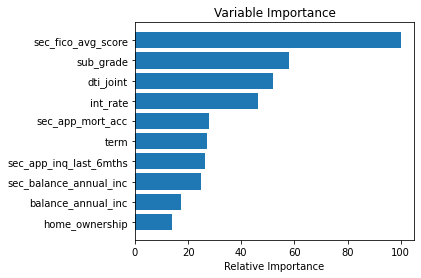

In [107]:
feature_importance = gbtree.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .05
# plt.subplot(1, 2, 2)
plt.figure(figsize=(5, 4))
plt.barh(pos[-10:], feature_importance[sorted_idx][-10:], align='center')
plt.yticks(pos[-10:], X_train.keys()[sorted_idx][-10:])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig(os.path.join('plots/Joint_features_weight.png'))
plt.show()


In [68]:
 X_train.keys()[sorted_idx]

Index(['pub_rec', 'open_acc_6m', 'open_il_12m', 'open_il_24m',
       'pub_rec_bankruptcies', 'open_act_il', 'verification_status_joint',
       'open_rv_24m', 'inq_fi', 'open_rv_12m', 'verification_status',
       'fico_avg_score', 'total_cu_tl', 'mort_acc', 'inq_last_12m', 'dti',
       'all_util', 'sec_app_num_rev_accts', 'grade', 'mths_since_rcnt_il',
       'sec_app_open_act_il', 'sec_app_open_acc', 'il_util',
       'credit_line_ratio', 'inst_amnt_ratio', 'revol_util', 'annual_inc',
       'emp_length', 'annual_inc_joint', 'revol_bal', 'sec_credit_hist',
       'purpose', 'revol_bal_joint', 'max_bal_bc', 'credit_hist',
       'total_bal_il', 'sec_app_revol_util', 'home_ownership',
       'balance_annual_inc', 'sec_balance_annual_inc',
       'sec_app_inq_last_6mths', 'term', 'sec_app_mort_acc', 'int_rate',
       'dti_joint', 'sub_grade', 'sec_fico_avg_score'],
      dtype='object')

In [69]:
keep_columns=['credit_hist', 'total_bal_il',
       'home_ownership', 'balance_annual_inc', 'sec_app_revol_util',
       'sec_balance_annual_inc', 'term', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'dti_joint', 'sec_fico_avg_score', 'sub_grade']
select_X_train=X_train[keep_columns]
select_X_test=X_test[keep_columns]

In [70]:
#define the param grid
# Parameters of pipelines can be set using ‘__’ separated para
clf_grid = {
    "gbtree__max_depth":[3,5,8],
    'gbtree__learning_rate': [0.01,0.05,0.1],
    'gbtree__n_estimators' : [100,500,1000],
    }

#define the pipeline
model_pipe = Pipeline([('gbtree', GradientBoostingClassifier())])

#define the classifer
clf = GridSearchCV(model_pipe,
                   clf_grid,
                   n_jobs=-1,
                   cv=4, 
                   verbose=50, 
                   scoring='roc_auc')


#fit to training data
clf.fit(select_X_train, y_train)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('gbtree',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gbtree__learning_rate': [0.01, 0.05, 0.1],
                         'gbtree__max_depth': [3, 5, 8],
                         'gbtree__n_estimators': [100, 500, 1000]},
             scoring='roc_auc', verbose=50)

In [109]:
print("Best model parameters: \n")
print(clf.best_params_ )
print("Best model score: \n")
print(clf.best_score_)

Best model parameters: 

{'gbtree__learning_rate': 0.01, 'gbtree__max_depth': 3, 'gbtree__n_estimators': 1000}
Best model score: 

0.7250516586440983


In [110]:
y_pred = clf.predict(select_X_test)
confusion_matrix(y_test, y_pred)

array([[3501,  432],
       [1552,  752]], dtype=int64)

In [111]:
f1_gb = f1_score(y_test, y_pred)

print("f1_gb (binary): {}\n".format(f1_gb))
print(classification_report(y_test,y_pred))

f1_gb (binary): 0.43119266055045874

              precision    recall  f1-score   support

           0       0.69      0.89      0.78      3933
           1       0.64      0.33      0.43      2304

    accuracy                           0.68      6237
   macro avg       0.66      0.61      0.61      6237
weighted avg       0.67      0.68      0.65      6237



In [112]:
fpr, tpr, thresholds = roc_curve(y_test,
                                 clf.predict_proba(select_X_test)[:,1],
                                 pos_label=1)

In [113]:
precision, recall, thresholds = precision_recall_curve(y_test,
                                                       clf.predict_proba(select_X_test)[:,1],
                                                       pos_label=1)

In [114]:
gb_auc = roc_auc_score(y_test, clf.predict_proba(select_X_test)[:,1])
print("gb_auc: {}".format(gb_auc)) 

gb_auc: 0.7088200006356471


In [115]:
#define location to save trained model
save_model_dir = os.path.join('models','gb_cv_compact_joint.pkl')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(clf,
                handle)

Saving model at: models\gb_cv_compact_joint.pkl


In [116]:
select_X_train=X_train[keep_columns].values
select_X_test=X_test[keep_columns].values

In [117]:
y_train=y_train.values

In [118]:
from tqdm import tqdm

auc_arr = []
for _ in tqdm(range(100)):
    idx = np.random.choice(np.arange(len(select_X_train)), 8000, replace=True)
    X_temp = select_X_train[idx]
    y_temp = y_train[idx]
        
    #instantiate classifier
    clf=GradientBoostingClassifier(learning_rate=0.01, n_estimators = 1000,max_depth=3)
    #fit to new data
    clf.fit(X_temp, y_temp)
    
    #predictions and scoring
    score = roc_auc_score(y_test, clf.predict_proba(select_X_test)[:,1])
    auc_arr.append(score)

100%|██████████| 100/100 [43:45<00:00, 26.25s/it]


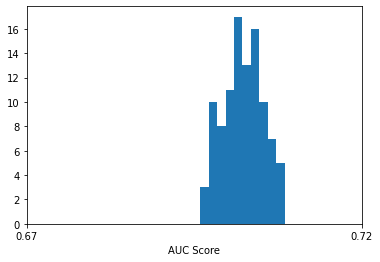

In [119]:
plt.hist(auc_arr)
plt.xlabel("AUC Score")
plt.xticks(np.arange(0.67, 0.77, 0.05))
plt.savefig(os.path.join("plots", 'auc_632_sampling_joint.png'))
plt.show()